In [2]:
from IPython.display import Image

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [318]:
%run -i WN_functions.py

<Figure size 432x288 with 0 Axes>

As deep learning networks grow in use and prominence in solving some data science and machine learning problems. Many issues in real world implementation around ethics and robustness have started to become apparent due to implicit bias due their complexity. Much of this bias has previously been not as visible as simpler classical techniques such as regression. In recent history many researchers have begun to develop techniques to identify the internal mechanics of these networks, methods such as activation maximization to uncover hidden biases and potential weaknesses of these networks.

This post takes inspiration from the paper White Noise Analysis of Neural Networks by Ali Borji and Sikun Lin, which proposes the use of 2 methods: classification images and spike triggered analysis to visualize hidden biases of CNN networks in image processing and classification.

For this task we implemented a Lenet network, which contains two sequential 5x5 2 dimensional Convolutional networks with maximum 2d pooling layers of 2 channels on both of their outputs followed by three fully connected layers of 120, 84 and 10 (the number of response classes of both problems). 

And also a modified version of the CNN presented in the original paper except with the pooling layers switched to average pooling instead of maximum pooling, this giving 2 2d convolutional networks with 5x5 kernels with 2 channel average 2d pooling layers following each, finally two fully connected layesr of 500 and 10 widths.

The implementation will be in pytorch package and will make use of a CUDA GPU implementation.

## MNIST Train models

First we will train the two networks on the MNIST dataset: which contains 70,000 28x28 black and white images representing the digits zero through nine. It is further split into 60,000 training images and 10,000 test images. 


In [8]:
train_loaderMNIST, test_loaderMNIST = loadMNIST()
train_loader_FashMNIST, test_loader_FashMNIST = loadFashMNIST()

In [24]:
model1 = LeNet()
# model2 = model_2nd_CNN()
# # trainModel(model1,  15, "testCNN",train_loaderMNIST, test_loaderMNIST)
bestLNModelString = trainModel(model1,  5, "MNIST_LeNet",train_loaderMNIST, test_loaderMNIST)
# modelsecond = trainModel(modelsecond,  15, "2ndCNNAVG",train_loaderMNIST, test_loaderMNIST)
print(f'best LeNetmodel name {bestLNModelString}')
# model2 = LeNet()
# model3 = model_2nd_CNN()
# trainModel(model1,  15, "testCNN",train_loaderMNIST, test_loaderMNIST)
# trainModel(model2,  15, "lenet_JUNK",train_loaderMNIST, test_loaderMNIST)

 Best model saved.[51456/60000 (86%)]	Loss: 1.595825
 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 1.612879	 Test Accuracy: 84.4900%
 Best model saved.[51456/60000 (86%)]	Loss: 1.573978
 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 1.589655	 Test Accuracy: 87.0600%
 Best model saved.[51456/60000 (86%)]	Loss: 1.488929
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 1.499248	 Test Accuracy: 96.5100%
 Best model saved.[51456/60000 (86%)]	Loss: 1.510322
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 1.487598	 Test Accuracy: 97.1600%
 Best model saved.[51456/60000 (86%)]	Loss: 1.490633
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 1.473192	 Test Accuracy: 97.7600%
best LeNetmodel name MNIST_LeNetfin_epoch_4.pth


In [25]:
# # model2 = LeNet()
model2 = model_2nd_CNN()
# # trainModel(model1,  15, "testCNN",train_loaderMNIST, test_loaderMNIST)
bestSecCNNModelString = trainModel(model2,  5, "MNIST_2ndCNN",train_loaderMNIST, test_loaderMNIST)
# modelsecond = trainModel(modelsecond,  15, "2ndCNNAVG",train_loaderMNIST, test_loaderMNIST)
print(f'best 2nd CNN model name {bestSecCNNModelString}')
# model2 = LeNet()
# model3 = model_2nd_CNN()
# trainModel(model1,  15, "testCNN",train_loaderMNIST, test_loaderMNIST)
# trainModel(model2,  15, "lenet_JUNK",train_loaderMNIST, test_loaderMNIST)

 Best model saved.[51456/60000 (86%)]	Loss: 1.633313
 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 1.652049	 Test Accuracy: 85.1200%
 Best model saved.[51456/60000 (86%)]	Loss: 1.504694
 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 1.477231	 Test Accuracy: 96.4100%
 Best model saved.[51456/60000 (86%)]	Loss: 1.486759
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 1.479927	 Test Accuracy: 97.5000%
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 1.504253	 Test Accuracy: 97.2700%
 Best model saved.[51456/60000 (86%)]	Loss: 1.473584
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 1.509001	 Test Accuracy: 98.1400%
best 2nd CNN model name MNIST_2ndCNNfin_epoch_4.pth


Both Models perform to a very high test accuracy on this dataset, the number of training iterations was intentially kept low to introduce more bias into this problem, as when using 15 iterations the models were very close to perfect with test accuracies above 99%. It is important to note that the test and training sets are well balanced with an equal amount of all classes, therefore we will stick with accuracy as a general metric rather than metrics such as F1 score. In the following section we will take a closer look at the performance of the best models on a class by class way using confusion matrices

In [10]:
modelLN = LeNet()
modelLN.cuda()

modelLN.load_state_dict(torch.load("MNIST_LeNetfin_epoch_4.pth")['model'])

<All keys matched successfully>

In [30]:

modelsecond = model_2nd_CNN()
modelsecond .cuda()
modelsecond .load_state_dict(torch.load("MNIST_2ndCNNfin_epoch_4.pth")['model'])

<All keys matched successfully>

In [11]:
bestModelConf(modelLN, test_loaderMNIST)
plt.savefig('LeNet_MNIST_TestConf.jpg')
plt.close()

In [68]:
bestModelConf(modelsecond, test_loaderMNIST)
plt.savefig('Second_MNIST_TestConf.jpg')
plt.close()

<table><tr>
<td>  <img src="LeNet_MNIST_TestConf.jpg" alt="Drawing" style="width: 900px;"/> </td>
<td>  <img src="Second_MNIST_TestConf.jpg" alt="Drawing" style="width: 900px;"/> </td>
</tr>

</table>
<figcaption align = "center"><b>Confusion matrix on Test MNIST data for LeNet Network (left) and 2nd CNN (Right)  </b>

We can see from the above confustion matrices that both are solid performers, however we can see that LeNet does have some issues with its predictions of numbers outside of 1,5,6 and 9. It has the most issues predicting 8 with 4% misclassification. 

We find the second network has most of its issues with incorrect predictions of 4 and zero

Using the classification images concept, we will mix actual data with noise according to the $\gamma$ proportional constant:
generally speaking

$t= (1 -\gamma) n +  \gamma s$

where $s =$ original image/signal

$n =$ randomly generated white noise

$t =$ final mixed images

We will then give these to our two networks for classification, we then take the mean noise component only of the classified images and subtract all other classified classes mean noise.

Given we have similar amounts of classes in the dataset we would likely get a similar amount of finally classified mixed messages, so we can simplify and get the classification image as such:

$c = \bar n_{targetClass} - \bar n_{otherClasses}$

where $\bar n_{targetClass} =$ mean of the noise component only of the mixed images classified as our target class 
$ \bar n_{otherClasses} =$ mean of the noise component only of the mixed images classified as any other class than our target


In [36]:
%pylab inline

for gamma in [0,0.1,0.2,0.3,0.5]:
    classificationImageSaver(modelLN, 
                             test_loaderMNIST,
                             10000,
                             100, 
                             gamma, f'CI_MNIST_LN_{gamma}.pt')
    saveClassImageGraphs(f'CI_MNIST_LN_{gamma}.pt',f'graphs/CI_MNIST_LM_{gamma}.png',modelLN)

99.0


In [37]:
# # del modelLN
# # model = model_first_CNN()
# modelsecond = model_2nd_CNN()
# modelsecond .cuda()
# # bestSecCNNModelString = MNIST_2ndCNNfin_epoch_11.pth
# modelsecond .load_state_dict(torch.load(bestSecCNNModelString)['model'])

In [38]:
for gamma in [0,0.1,0.2,0.3,0.5]:
    classificationImageSaver(modelsecond, 
                             test_loaderMNIST,
                             10000,
                             100, 
                             gamma, f'CI_MNIST_2ndCNN_{gamma}.pt')
    saveClassImageGraphs(f'CI_MNIST_2ndCNN_{gamma}.pt',f'graphs/CI_MNIST_2ndCNN_{gamma}.png',modelsecond)

99.0


<table>
    <th align= "center">&gamma;</th>
    <th align= "center">LeNet</th>
    <th align= "center">2nd CNN</th>
<tr>
<td>0.5</td>
<td>  <img src="graphs/CI_MNIST_LM_0.5.png" alt="Drawing" style="width: 500px;"/> </td>
<td>  <img src="graphs/CI_MNIST_2ndCNN_0.5.png" alt="Drawing" style="width: 500px;"/> </td>
</tr>
    
    
<tr>
<td>0.3</td>
<td>  <img src="graphs/CI_MNIST_LM_0.3.png" alt="Drawing" style="width: 500px;"/> </td>
<td>  <img src="graphs/CI_MNIST_2ndCNN_0.3.png" alt="Drawing" style="width: 500px;"/> </td>
</tr>

<tr>
<td>0.2</td>
<td> <img src="graphs/CI_MNIST_LM_0.2.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="graphs/CI_MNIST_2ndCNN_0.2.png" alt="Drawing" style="width: 500px;"/> </td>
</tr>
<tr>
<td>0.1</td>
<!--     <em style="color: grey">Gamma = 0.1</em> -->
<td> <img src="graphs/CI_MNIST_LM_0.1.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="graphs/CI_MNIST_2ndCNN_0.1.png" alt="Drawing" style="width: 500px;"/> </td>
</tr>
    <tr>
<td>0.0</td>
<!-- <em style="color: grey">Gamma = 0</em> -->
<td> <img src="graphs/CI_MNIST_LM_0.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="graphs/CI_MNIST_2ndCNN_0.png" alt="Drawing" style="width: 500px;"/> </td>
</tr>
</table>
<figcaption align = "center"><b>Classification Images for LeNet Network (left) and 2nd CNN (Right) ( &gamma; = 0.5,0.3, 0.2, 0.1 and 0 (descending)  </b>

We can see that a gamma of 0.3 seems to give good results, with more noise some classes do not appear at all and others are very noisy, interestingly at 0.3 some classes images are well defined, but start to become more noisy as we move to 0.5 in both networks. As we can see below with the exception of class one's classification image in the 2nd CNN all other classes classification image are classified correctly when fed back into the trained networks.

MNIST LeNet classification image at gamma = 0.3


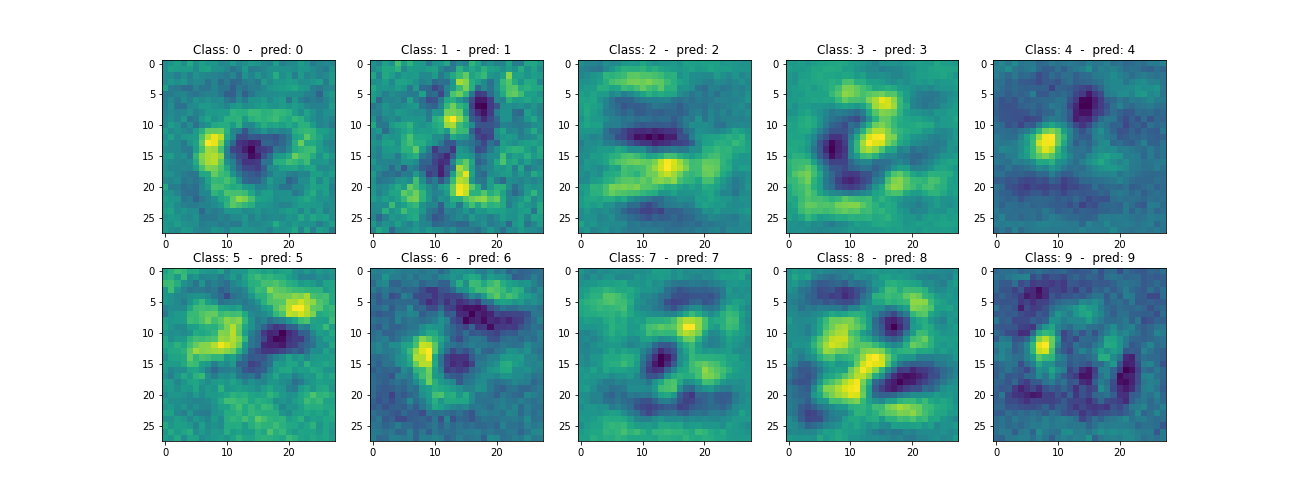

In [418]:
print("MNIST LeNet classification image at gamma = 0.3")
Image(filename=f'graphs/CI_MNIST_LM_0.3.png')


<!-- ![Classification Image](graphs/CI_MNIST_LM_0.png) -->
<!--  <div class="row">
  <div class="column">
    <img src="graphs/CI_MNIST_LM_0.3.png" alt="Classification Image" title="Classification Image" 
     width="400" 
     height="500"/>
<img src="graphs/CI_MNIST_LM_0.2.png" alt="Classification Image" title="Classification Image" width="400" 
     height="500"/>
    
    </div>
    
  <div class="column">
    <img src="graphs/CI_MNIST_LM_0.1.png" alt="Classification Image" title="Classification Image" width="400" 
     height="500" />
<img src="graphs/CI_MNIST_LM_0.png" alt="Classification Image" title="Classification Image" width="400" 
     height="500" />

    </div>
</div> 


<figcaption align = "center"><b>Classification Images for LeNet Network &gamma; = 0.3, 0.2, 0.1 and 0 (descending) </b></figcaption> -->


<!-- <figcaption>This is a caption</figcaption> -->
<!-- <figure>    -->

MNIST 2nd CNN classification image at gamma = 0.3


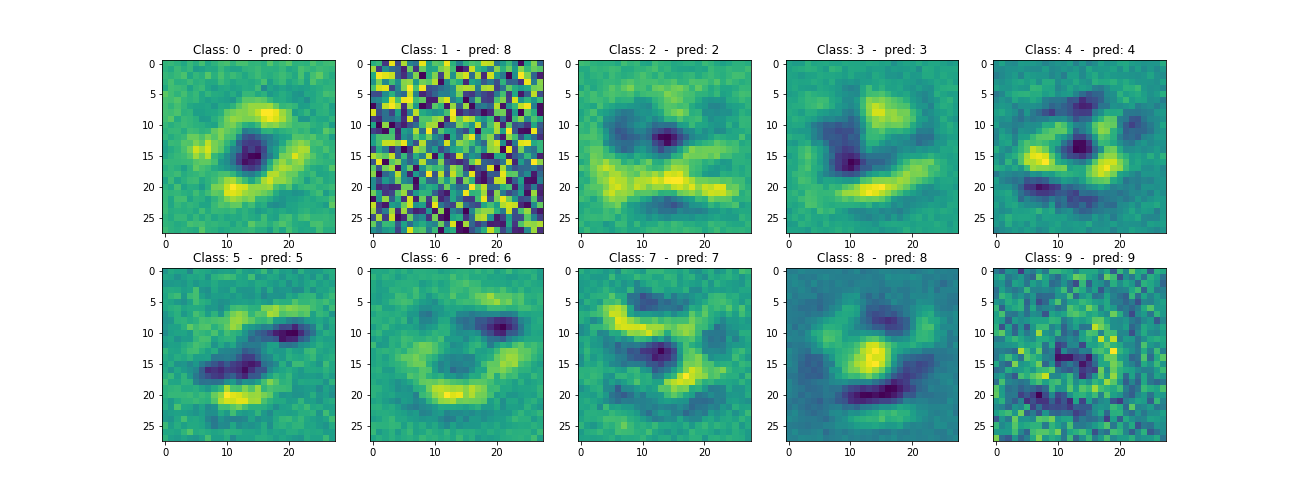

In [419]:
print("MNIST 2nd CNN classification image at gamma = 0.3")
Image(filename=f"graphs/CI_MNIST_2ndCNN_0.3.png")

A useful way of assessing the information contained in our classification images is to consider them as a templates. In the paper they compare these templates and also average real images classified in a particular class to the test data using the dot product and find the "closest" matching classification image. In the following section we will average the image tensors that are classified for each class by both models, and also the Classification Images previously obtained at $\gamma = 0.3$.

In [62]:
## data set averages per class
averageDSImageSaver(modelLN, test_loaderMNIST, f'MNIST_LN_AverageImage.pt')
averageDSImageSaver(modelsecond, test_loaderMNIST, f'MNIST_2nd_AverageImage.pt')

saveClassImageGraphs(f'MNIST_LN_AverageImage.pt',f'graphs/MNIST_LN_AverageImage.png',modelLN)
saveClassImageGraphs(f'MNIST_2nd_AverageImage.pt',f'graphs/MNIST_2nd_AverageImage.png',modelsecond)

0.0


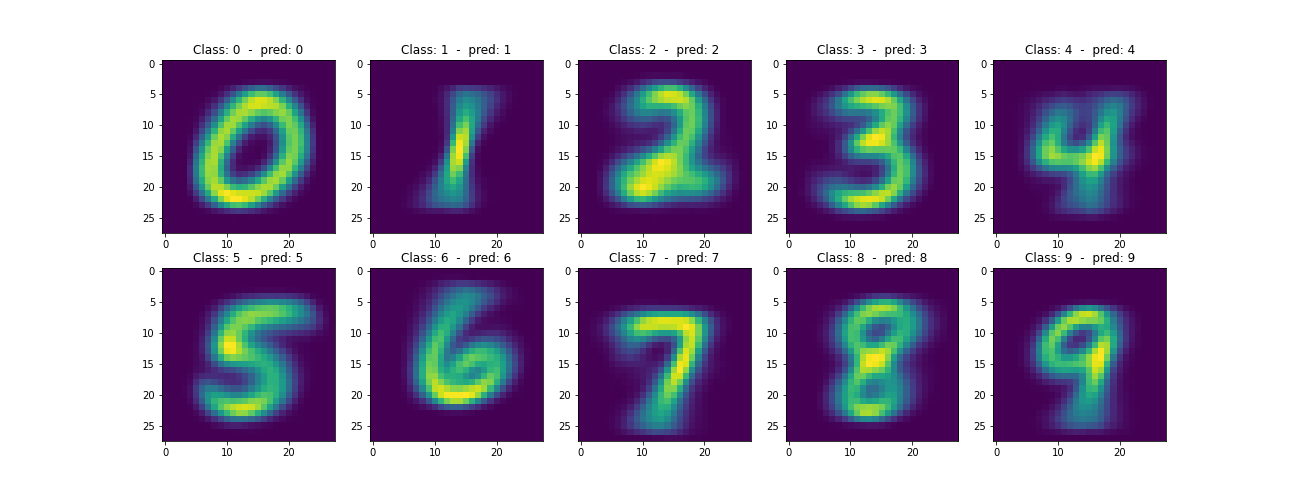

In [64]:
Image(filename=f'graphs/MNIST_LN_AverageImage.png')

In [204]:
## mean image classifier
print("Classifier using mean Dataset Image LeNet")
displayDDClassifier('MNIST_LN_AverageImage.pt',test_loaderMNIST,average_name = "dataset image")
plt.savefig('LeNet_MNIST_AvgImageClassifier_Conf.jpg')
plt.close()

## Bias image classifier
print("Classifier using classification image LeNet")
displayDDClassifier('CI_MNIST_LN_0.3.pt',test_loaderMNIST)
plt.savefig('LeNet_MNIST_ClassImgClassifier_Conf.jpg')
plt.close()
## mean image classifier
print("Classifier using mean Dataset Image 2nd CNN")
displayDDClassifier('MNIST_2nd_AverageImage.pt',test_loaderMNIST,average_name = "dataset image")
plt.savefig('2nd_MNIST_AvgImageClassifier_Conf.jpg')
plt.close()

## Bias image classifier
print("Classifier using classification image 2nd CNN")
displayDDClassifier('CI_MNIST_2ndCNN_0.3.pt',test_loaderMNIST)
plt.savefig('2nd_MNIST_ClassImgClassifier_Conf.jpg')
plt.close()

Classifier using mean Dataset Image LeNet
(10, 784)
Accuracy:  0.8252
Classifier using classification image LeNet
(10, 784)
Accuracy:  0.5856
Classifier using mean Dataset Image 2nd CNN
(10, 784)
Accuracy:  0.8248
Classifier using classification image 2nd CNN
(10, 784)
Accuracy:  0.4855


The classification images are reasonably strong classifiers when used in this way, althought not as strong as the mean images. If we look at the confusion matrices, particularly for lenet, there is only only class that has a class accuracy less than 0.5 (that being 3) and five classes with accuracies above 80%. In the second CNN the results are not as impressive, but in some classes such as 2, 5, 6 and 7 they do a better job as the average images as a classifier. Unsurprisingly class 1 in this model was the weakest, which is due to its noisy nature.

<table>
    <th align= "center"> </th>
    <th align= "center">LeNet</th>
    <th align= "center">2nd CNN</th>
<tr>
<td>Classification Images</td>
<td>  <img src="LeNet_MNIST_ClassImgClassifier_Conf.jpg" alt="Drawing" style="width: 500px;"/> </td>
<td>  <img src="2nd_MNIST_ClassImgClassifier_Conf.jpg" alt="Drawing" style="width: 500px;"/> </td>
</tr>
<td>Average Dataset Images</td>
<td>  <img src="LeNet_MNIST_AvgImageClassifier_Conf.jpg" alt="Drawing" style="width: 500px;"/> </td>
<td>  <img src="2nd_MNIST_AvgImageClassifier_Conf.jpg" alt="Drawing" style="width: 500px;"/> </td>
</tr>    
    
</table>
<figcaption align = "center"><b>Classifier performance using our classification image and average dataset image templates for MNIST</b>

The paper also proposed Spike Triggered Analysis to find mean layer activation maps for specific layers in the model. We will perform this technique by feeding the model many many samples of whitenoise to observe outputs of particular layers, in this case the first and last convolutional layers of both.

In [421]:
GetWNActivation(modelLN,"noise_acts_MN_LM")
GetRealActivation(modelLN,"realDat_acts_MN_LM",train_loaderMNIST)

File 20/20
100%|██████████| 200/200 [00:01<00:00, 147.35it/s]
235it [00:07, 29.52it/s]


Lenet Model
conv2 layer


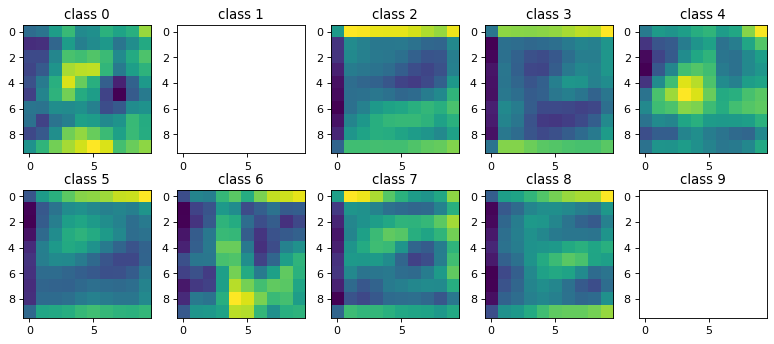

conv1 layer


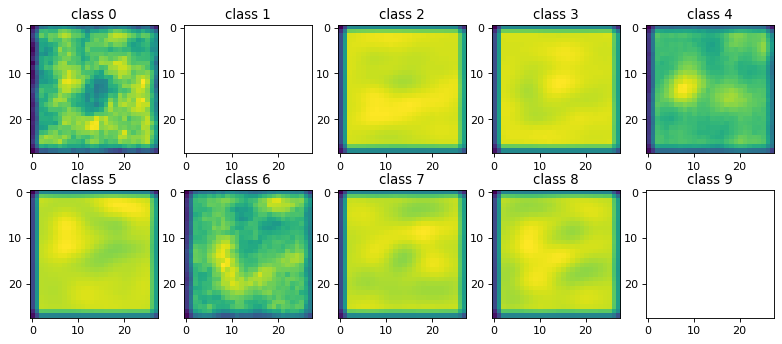

In [425]:
print("Lenet Model White noise generated mean layer activations")
LoadNoiseAndPlotActs("noise_acts_MN_LM")

conv2


<Figure size 1050x300 with 0 Axes>

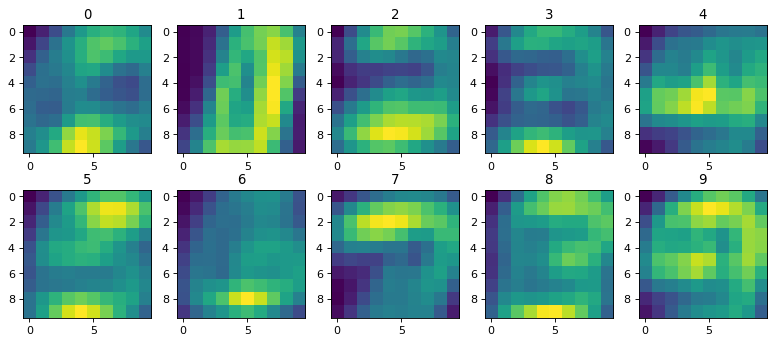

conv1


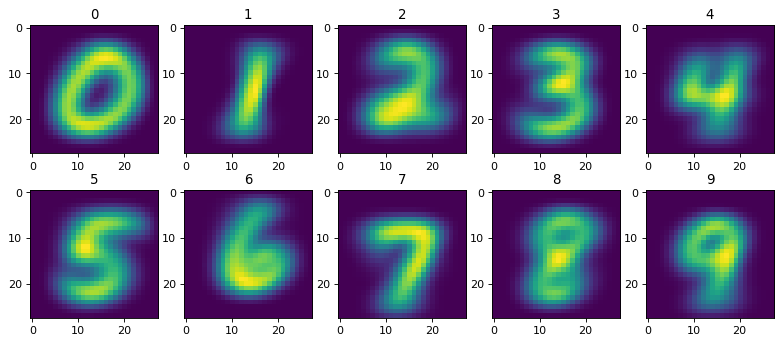

In [424]:
print("Lenet Model Real data generated mean layer activations")
LoadRealDatAndPlotActs("realDat_acts_MN_LM",)

In [54]:
GetWNActivation(modelsecond,"noise_acts_MN_2nd",20)
GetRealActivation(modelsecond,"realDat_acts_MN_2nd",train_loaderMNIST)

File 20/20
100%|██████████| 200/200 [00:01<00:00, 134.92it/s]
235it [00:08, 27.35it/s]


2nd CNN Model White noise generated mean layer activations
conv2 layer


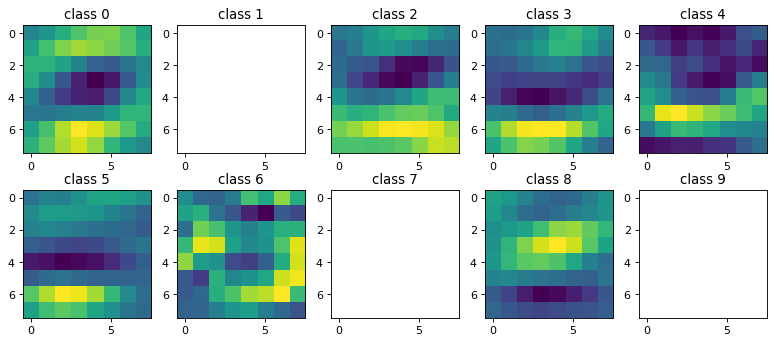

conv1 layer


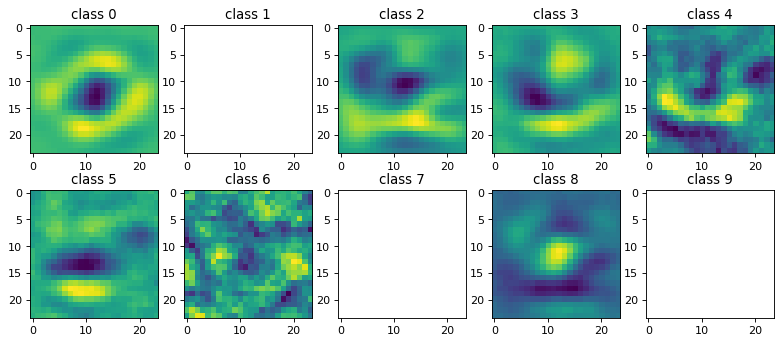

In [426]:
print("2nd CNN Model White noise generated mean layer activations")
LoadNoiseAndPlotActs("noise_acts_MN_2nd",20)

2nd CNN Model Real Data generated mean layer activations
conv2


<Figure size 1050x300 with 0 Axes>

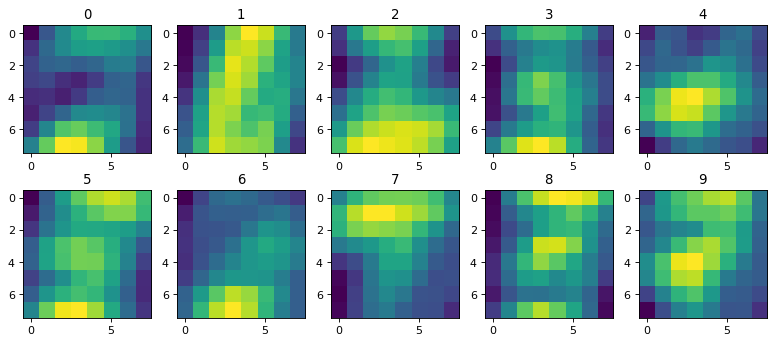

conv1


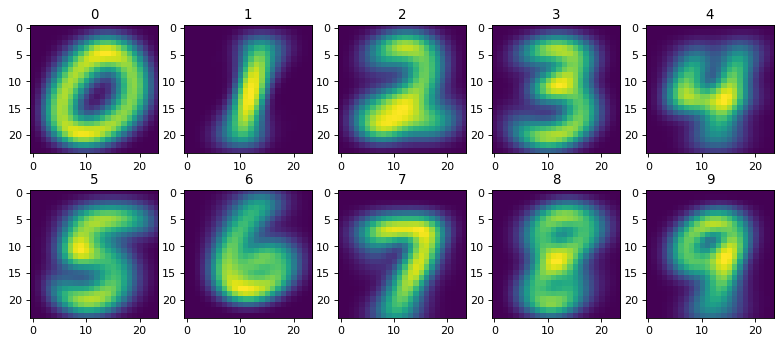

In [427]:
print("2nd CNN Model Real Data generated mean layer activations")
LoadRealDatAndPlotActs("realDat_acts_MN_2nd",)

We see some areas of similar features in the 2nd convolutional layer mean activation maps for the noisy data and real data for both, though not exactly the same, this would seem to suggest there are some areas not present in real data that can still trigger these layers. In the paper one of the Mean activation maps was used for an adversial attack to change the class without (to human eyes) changing its real class, its possible we may be able to use these noise generated activation maps in a reverse fashion, to remove areas that are contributing to classification in, but don't correspond with what a human would interpret as being an important feature of the real class.

It is interesting to note that we did not get the classifier to class noise in very strong classes, in both networks we were missing classes for those that had 99% accuracy in that class, interestingly we saw a similar mechanism with our classification images, in the LeNet network classes 1 and 9 are visually the noisiest the classification images for a given value of $\gamma$. 

With this in mind the missing classes in the SPA are already some of the most unbiased prediction aspects of the model. This could be remedied by a larger amount of generated white noise, but given this was starting to exceed available resources when increasing the number of noise samples presented and the fact that they wouldn't be as useful in our potential proposed method for improving model performance. It was decided not to pursue this avenue.

In a similar way that the authors of the paper add the last convolutional mean layer's activation map that corresponded with the car class to an image of a frog to trick the network in Figure 7C. I had the idea to improve misclassification of certain predictions by removing a small amount of the Conv2 mean layer's noise activation map for the some of the worst offending classes in terms of misclassification (in a linear combination). 

Generally speaking 

Final Image $ = s - k\times C$

where s is the original image, k a  coeffecient which was found to be around 0.02-0.1 for best results and C a mixed image from the conv2 mean noiseactivations.

$C = \sum(Conv2_i)/n$

where i is the set of most misclassified classes and n the number of classes selected. 

The code blocks of the calculation for the image mixing, have been included in the notebook for clarity.



For the LeNet model, after visually inspecting the test confusion matric, class 0, 4, 7 and 8 were chosen, as the predictions of these classes by the model contained many false positives that were actually other classes. The resultant image we will apply as an average of these 3 classes mean activation layers is shown below:

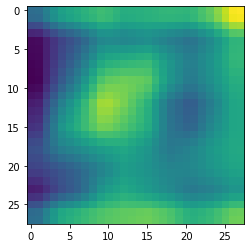

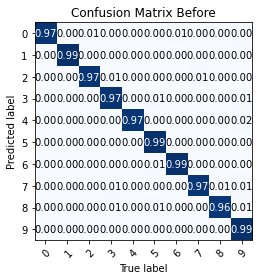

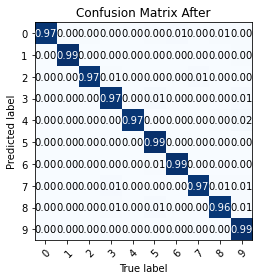

Before Accuracy 0.9776
After Accuracy 0.978


In [479]:
import cv2
conv2_actsLM, _,_ = LoadNoiseAndreturn("noise_acts_MN_LM",20)
k = -0.05
conv2_acts = conv2_actsLM
signal = test_loaderMNIST.dataset.data.type(torch.FloatTensor)
# signal =signal/256
C = (cv2.resize(conv2_acts[0].numpy(), (28, 28)) + 
          cv2.resize(conv2_acts[4].numpy(), (28, 28)) +
          cv2.resize(conv2_acts[7].numpy(), (28, 28))+ 
          cv2.resize(conv2_acts[8].numpy(), (28, 28))
         ) / 4

plt.imshow(C)

finalImages = signal+ (k)*C*256
beforeAcc, afterAcc = bestModelConf(modelLN, test_loaderMNIST,True,'Confusion Matrix', finalImages)

print(f'Before Accuracy {beforeAcc}')
print(f'After Accuracy {afterAcc}')

I also tried doing a similar method but using classification images, this appeared to work marginally better.

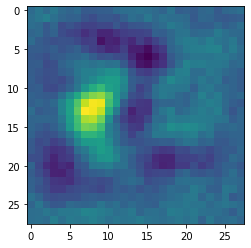

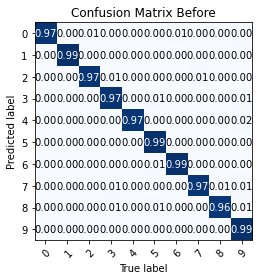

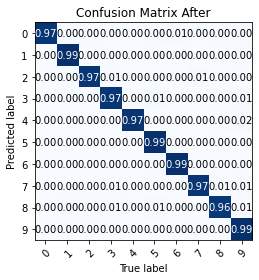

Before Accuracy 0.9776
After Accuracy 0.9783


In [493]:

# conv2_acts2nd, _,_ = LoadNoiseAndreturn("noise_acts_MN_2nd",20)
CI_acts = torch.load(f'CI_MNIST_LN_0.3.pt')
import cv2
k = -1
signal = test_loaderMNIST.dataset.data.type(torch.FloatTensor)
# signal =signal/256
CI_acts = CI_acts 

C = (CI_acts[0].view(-1,28) + 
          CI_acts[4].view(-1,28) +
          CI_acts[7].view(-1,28)+
          CI_acts[8].view(-1,28)
         ) / 4
plt.imshow(C)
finalImages4 = signal+ (k)*C*256
beforeAcc, afterAcc = bestModelConf(modelLN, test_loaderMNIST,True,'Confusion Matrix', finalImages4)
print(f'Before Accuracy {beforeAcc}')
print(f'After Accuracy {afterAcc}')



For the second CNN model classes 0, 4 and 8 were selected in a similar way. 

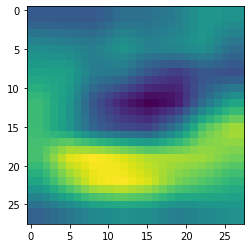

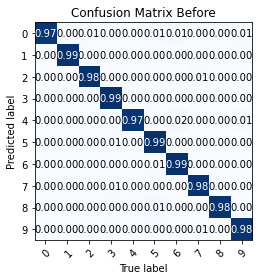

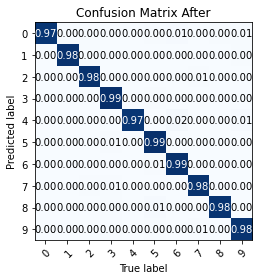

Before Accuracy 0.9814
After Accuracy 0.9814


In [505]:
conv2_acts2nd, _,_ = LoadNoiseAndreturn("noise_acts_MN_2nd",20)
import cv2
k = -0.05
signal = test_loaderMNIST.dataset.data.type(torch.FloatTensor)
# signal =signal/256
conv2_acts = conv2_acts2nd
C = (cv2.resize(conv2_acts[0].numpy(), (28, 28)) + 

          cv2.resize(conv2_acts[4].numpy(), (28, 28)) +
          cv2.resize(conv2_acts[8].numpy(), (28, 28))
         ) / 3

plt.imshow(C)



finalImages = signal+ (k)*C*256
beforeAcc, afterAcc = bestModelConf(modelsecond, test_loaderMNIST,True,'Confusion Matrix', finalImages)

print(f'Before Accuracy {beforeAcc}')
print(f'After Accuracy {afterAcc}')

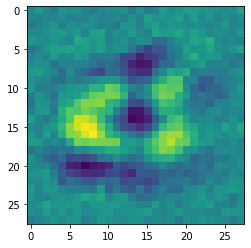

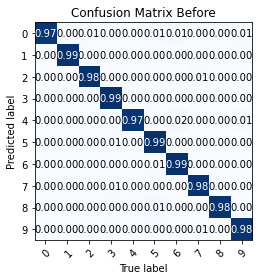

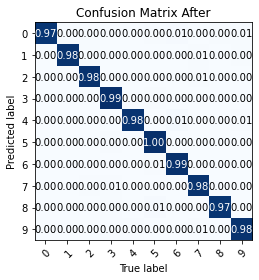

Before Accuracy 0.9814
After Accuracy 0.9821


In [504]:
# conv2_acts2nd, _,_ = LoadNoiseAndreturn("noise_acts_MN_2nd",20)
CI_acts = torch.load(f'CI_MNIST_2ndCNN_0.3.pt')
import cv2
k = -1.5
signal = test_loaderMNIST.dataset.data.type(torch.FloatTensor)
# signal =signal/256
CI_acts = CI_acts 

C = (CI_acts[0].view(-1,28) + 
          CI_acts[4].view(-1,28) +
          CI_acts[8].view(-1,28)
         ) / 3
plt.imshow(C)
finalImages4 = signal+ (k)*C*256
beforeAcc, afterAcc = bestModelConf(modelsecond, test_loaderMNIST,True,'Confusion Matrix', finalImages4)
print(f'Before Accuracy {beforeAcc}')
print(f'After Accuracy {afterAcc}')


The differences in perfomance are small and given these are quite tuned predictors these results were not large enough to be conclusive. It does however seem that the classification images seem work work better for this method.

## Fashion MNIST Train models

Moving on to the MNIST Fashion dataset using the same two CNN networks introduced earlier. It is very similar in structure by has the following 10 classes:

0 - T-shirt/Top

1 - Pants

2 - Pullover

3 - Dress

4 - Coat

5 - Sandals

6 - Shirt

7 - Sneaker

8 - Bag

9 - Ankle boots

In [175]:
modelLN_FM = LeNet()

bestFash_LN_ModelString =trainModel(modelLN_FM,  15, "LN_FashMNIST",train_loader_FashMNIST, test_loader_FashMNIST)

print(f'best model name {bestFash_LN_ModelString}')

 Best model saved. [51456/60000 (86%)]	Loss: 1.751476
 Train Epoch: 1/15 [60000/60000 (100%)]	Loss: 1.668920	 Test Accuracy: 74.9700%
 Best model saved. [51456/60000 (86%)]	Loss: 1.646883
 Train Epoch: 2/15 [60000/60000 (100%)]	Loss: 1.597046	 Test Accuracy: 75.6900%
 Best model saved. [51456/60000 (86%)]	Loss: 1.638260
 Train Epoch: 3/15 [60000/60000 (100%)]	Loss: 1.644924	 Test Accuracy: 80.2000%
 Best model saved. [51456/60000 (86%)]	Loss: 1.684048
 Train Epoch: 4/15 [60000/60000 (100%)]	Loss: 1.671684	 Test Accuracy: 80.7000%
 Best model saved. [51456/60000 (86%)]	Loss: 1.617972
 Train Epoch: 5/15 [60000/60000 (100%)]	Loss: 1.598444	 Test Accuracy: 82.2100%
 Train Epoch: 6/15 [60000/60000 (100%)]	Loss: 1.660871	 Test Accuracy: 82.1600%
 Best model saved. [51456/60000 (86%)]	Loss: 1.581410
 Train Epoch: 7/15 [60000/60000 (100%)]	Loss: 1.627434	 Test Accuracy: 83.7800%
 Train Epoch: 8/15 [60000/60000 (100%)]	Loss: 1.619966	 Test Accuracy: 81.6300%
 Train Epoch: 9/15 [60000/60000 (100

In [178]:
modelsecond_FM = model_2nd_CNN()

bestFash_LN_ModelString =trainModel(modelsecond_FM,  15, "2nd_FashMNIST",train_loader_FashMNIST, test_loader_FashMNIST)

print(f'best model name {bestFash_LN_ModelString}')

 Best model saved. [51456/60000 (86%)]	Loss: 1.727470
 Train Epoch: 1/15 [60000/60000 (100%)]	Loss: 1.730623	 Test Accuracy: 66.7200%
 Best model saved. [51456/60000 (86%)]	Loss: 1.788242
 Train Epoch: 2/15 [60000/60000 (100%)]	Loss: 1.667136	 Test Accuracy: 70.4900%
 Best model saved. [51456/60000 (86%)]	Loss: 1.697862
 Train Epoch: 3/15 [60000/60000 (100%)]	Loss: 1.793105	 Test Accuracy: 73.5500%
 Train Epoch: 4/15 [60000/60000 (100%)]	Loss: 1.654843	 Test Accuracy: 71.2400%
 Train Epoch: 5/15 [60000/60000 (100%)]	Loss: 1.682954	 Test Accuracy: 72.6100%
 Best model saved. [51456/60000 (86%)]	Loss: 1.641394
 Train Epoch: 6/15 [60000/60000 (100%)]	Loss: 1.671582	 Test Accuracy: 81.6900%
 Best model saved. [51456/60000 (86%)]	Loss: 1.633155
 Train Epoch: 7/15 [60000/60000 (100%)]	Loss: 1.635912	 Test Accuracy: 83.3600%
 Train Epoch: 8/15 [60000/60000 (100%)]	Loss: 1.603088	 Test Accuracy: 83.1600%
 Best model saved. [51456/60000 (86%)]	Loss: 1.590220
 Train Epoch: 9/15 [60000/60000 (100

In [179]:
modelLN_Fash = LeNet()
modelLN_Fash.cuda()
bestFash_LN_ModelString = "LN_FashMNISTfin_epoch_10.pth"
modelLN_Fash.load_state_dict(torch.load(bestFash_LN_ModelString)['model'])

<All keys matched successfully>

In [181]:

modelsecond_Fash = model_2nd_CNN()
modelsecond_Fash .cuda()
modelsecond_Fash .load_state_dict(torch.load("2nd_FashMNISTfin_epoch_13.pth")['model'])

<All keys matched successfully>

In [184]:
bestModelConf(modelLN_Fash, test_loader_FashMNIST)
plt.savefig('LeNet_FashMNIST_TestConf.jpg')
plt.close()

In [185]:
bestModelConf(modelsecond_Fash, test_loader_FashMNIST)
plt.savefig('Second_FashMNIST_TestConf.jpg')
plt.close()

<table><tr>
<td>  <img src="LeNet_FashMNIST_TestConf.jpg" alt="Drawing" style="width: 900px;"/> </td>
<td>  <img src="Second_FashMNIST_TestConf.jpg" alt="Drawing" style="width: 900px;"/> </td>
</tr>

</table>
<figcaption align = "center"><b>Confusion matrix on Test Fashion MNIST data for LeNet Network (left) and 2nd CNN (Right)  </b>

Looking at the confusion matrices for our fitted models, we can see that unlike the original MNISt there is much more misclassification in some of the classes, resulting in a general accuracy for both models that is in the low 80% range for test accuracy, however we can see some claases are only 70-80% test accuracy (one is even 66%). 

We will again look at the classification images and build up a classifier to determine how informative they are.

In [187]:
%pylab inline

for gamma in [0,0.1,0.2,0.3,0.5]:
    classificationImageSaver(modelLN_Fash, 
                             test_loader_FashMNIST,
                             10000,
                             100, 
                             gamma, f'CI_FashMNIST_LN_{gamma}.pt')
    saveClassImageGraphs(f'CI_FashMNIST_LN_{gamma}.pt',f'graphs/CI_FashMNIST_LM_{gamma}.png',modelLN_Fash)

99.0


In [188]:
for gamma in [0,0.1,0.2,0.3,0.5]:
    classificationImageSaver(modelsecond_Fash, 
                             test_loader_FashMNIST,
                             10000,
                             100, 
                             gamma, f'CI_FashMNIST_2ndCNN_{gamma}.pt')
    saveClassImageGraphs(f'CI_FashMNIST_2ndCNN_{gamma}.pt',f'graphs/CI_FashMNIST_2ndCNN_{gamma}.png',modelsecond_Fash)

99.0


<table>
    <th align= "center">&gamma;</th>
    <th align= "center">LeNet</th>
    <th align= "center">2nd CNN</th>
<tr>
<td>0.5</td>
<td>  <img src="graphs/CI_FashMNIST_LM_0.5.png" alt="Drawing" style="width: 500px;"/> </td>
<td>  <img src="graphs/CI_FashMNIST_2ndCNN_0.5.png" alt="Drawing" style="width: 500px;"/> </td>
</tr>
    
    
<tr>
<td>0.3</td>
<td>  <img src="graphs/CI_FashMNIST_LM_0.3.png" alt="Drawing" style="width: 500px;"/> </td>
<td>  <img src="graphs/CI_FashMNIST_2ndCNN_0.3.png" alt="Drawing" style="width: 500px;"/> </td>
</tr>

<tr>
<td>0.2</td>
<td> <img src="graphs/CI_FashMNIST_LM_0.2.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="graphs/CI_FashMNIST_2ndCNN_0.2.png" alt="Drawing" style="width: 500px;"/> </td>
</tr>
<tr>
<td>0.1</td>
<!--     <em style="color: grey">Gamma = 0.1</em> -->
<td> <img src="graphs/CI_FashMNIST_LM_0.1.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="graphs/CI_FashMNIST_2ndCNN_0.1.png" alt="Drawing" style="width: 500px;"/> </td>
</tr>
    <tr>
<td>0.0</td>
<!-- <em style="color: grey">Gamma = 0</em> -->
<td> <img src="graphs/CI_FashMNIST_LM_0.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="graphs/CI_FashMNIST_2ndCNN_0.png" alt="Drawing" style="width: 500px;"/> </td>
</tr>
</table>
<figcaption align = "center"><b>Classification Images for LeNet Network (left) and 2nd CNN (Right) ( &gamma; = 0.5,0.3, 0.2, 0.1 and 0 (descending)  </b>

We can see that a gamma of 0.3 seems to give good and reasonably clear results again, this time however dispite having some noisy classification image in the 2nd CNN network all predictions from the models on the classification images match their classes for both networks.

We can see shapes that resemble the target classes for most of the classes for the first 4 classes (Top,Pants, Pull over and dress) some of the other classes are less distinct in the shapes of their classification images.

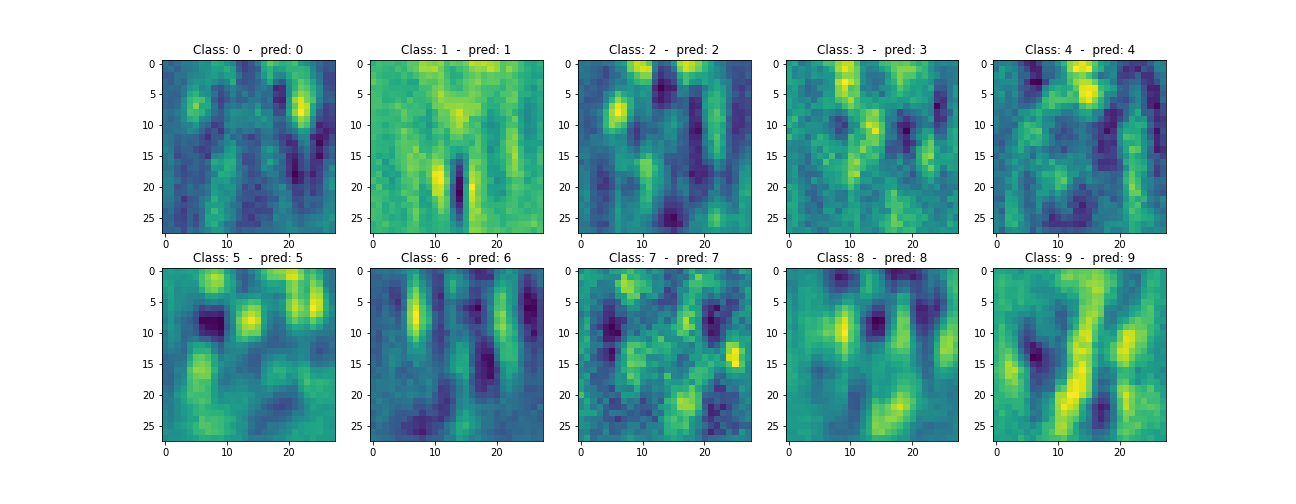

In [189]:
Image(filename=f'graphs/CI_FashMNIST_LM_0.3.png')

<!-- ![Classification Image](graphs/CI_MNIST_LM_0.png) -->
<!--  <div class="row">
  <div class="column">
    <img src="graphs/CI_MNIST_LM_0.3.png" alt="Classification Image" title="Classification Image" 
     width="400" 
     height="500"/>
<img src="graphs/CI_MNIST_LM_0.2.png" alt="Classification Image" title="Classification Image" width="400" 
     height="500"/>
    
    </div>
    
  <div class="column">
    <img src="graphs/CI_MNIST_LM_0.1.png" alt="Classification Image" title="Classification Image" width="400" 
     height="500" />
<img src="graphs/CI_MNIST_LM_0.png" alt="Classification Image" title="Classification Image" width="400" 
     height="500" />

    </div>
</div> 


<figcaption align = "center"><b>Classification Images for LeNet Network &gamma; = 0.3, 0.2, 0.1 and 0 (descending) </b></figcaption> -->


<!-- <figcaption>This is a caption</figcaption> -->
<!-- <figure>    -->

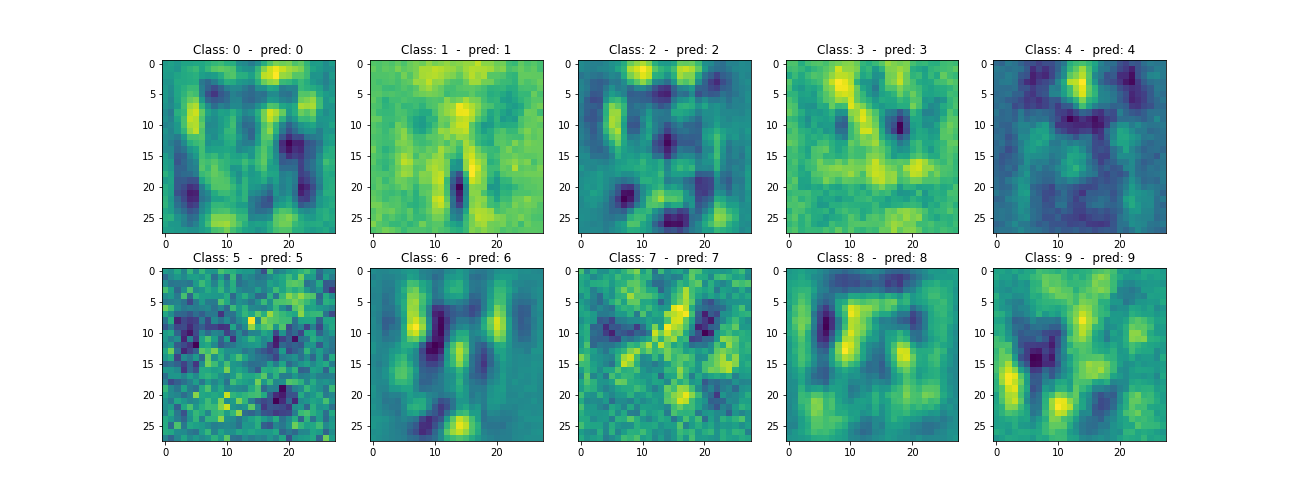

In [190]:
Image(filename=f"graphs/CI_FashMNIST_2ndCNN_0.3.png")

In [194]:
## data set averages per class
averageDSImageSaver(modelLN_Fash,test_loader_FashMNIST, f'FashMNIST_LN_AverageImage.pt')
averageDSImageSaver(modelsecond_Fash, test_loader_FashMNIST, f'FashMNIST_2nd_AverageImage.pt')

saveClassImageGraphs(f'FashMNIST_LN_AverageImage.pt',f'graphs/FashMNIST_LN_AverageImage.png',modelLN_Fash)
saveClassImageGraphs(f'FashMNIST_2nd_AverageImage.pt',f'graphs/FashMNIST_2nd_AverageImage.png',modelsecond_Fash)

0.0


In [205]:
## mean image classifier
print("Classifier using mean Dataset Image LeNet")
displayDDClassifier('FashMNIST_LN_AverageImage.pt',test_loader_FashMNIST,average_name = "dataset image")
plt.savefig('LeNet_FashMNIST_AvgImageClassifier_Conf.jpg')
plt.close()

## Bias image classifier
print("Classifier using classification image LeNet")
displayDDClassifier('CI_FashMNIST_LN_0.3.pt',test_loader_FashMNIST)
plt.savefig('LeNet_FashMNIST_ClassImgClassifier_Conf.jpg')
plt.close()
## mean image classifier
print("Classifier using mean Dataset Image 2nd CNN")
displayDDClassifier('FashMNIST_2nd_AverageImage.pt',test_loader_FashMNIST,average_name = "dataset image")
plt.savefig('2nd_FashMNIST_AvgImageClassifier_Conf.jpg')
plt.close()

## Bias image classifier
print("Classifier using classification image 2nd CNN")
displayDDClassifier('CI_FashMNIST_2ndCNN_0.3.pt',test_loader_FashMNIST)
plt.savefig('2nd_FashMNIST_ClassImgClassifier_Conf.jpg')
plt.close()

Classifier using mean Dataset Image LeNet
(10, 784)
Accuracy:  0.6876
Classifier using classification image LeNet
(10, 784)
Accuracy:  0.5169
Classifier using mean Dataset Image 2nd CNN
(10, 784)
Accuracy:  0.6855
Classifier using classification image 2nd CNN
(10, 784)
Accuracy:  0.4143


<table>
    <th align= "center"> </th>
    <th align= "center">LeNet</th>
    <th align= "center">2nd CNN</th>
<tr>
<td>Classification Image</td>
<td>  <img src="LeNet_FashMNIST_ClassImgClassifier_Conf.jpg" alt="Drawing" style="width: 500px;"/> </td>
<td>  <img src="2nd_FashMNIST_ClassImgClassifier_Conf.jpg" alt="Drawing" style="width: 500px;"/> </td>
</tr>
<td>Average Dataset Image</td>
<td>  <img src="LeNet_FashMNIST_AvgImageClassifier_Conf.jpg" alt="Drawing" style="width: 500px;"/> </td>
<td>  <img src="2nd_FashMNIST_AvgImageClassifier_Conf.jpg" alt="Drawing" style="width: 500px;"/> </td>
</tr>    
    
</table>
<figcaption align = "center"><b>Classifier performance using our classification image and average dataset image templates for Fashion MNIST</b>

Looking at both the classification images and 

In [207]:
GetWNActivation(modelLN_Fash,"noise_acts_MN_FashLM")
GetRealActivation(modelsecond_Fash,"realDat_acts_MN_FashLM",train_loader_FashMNIST)

File 20/20
100%|██████████| 200/200 [00:01<00:00, 160.35it/s]
235it [00:11, 19.67it/s]


conv2 layer


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


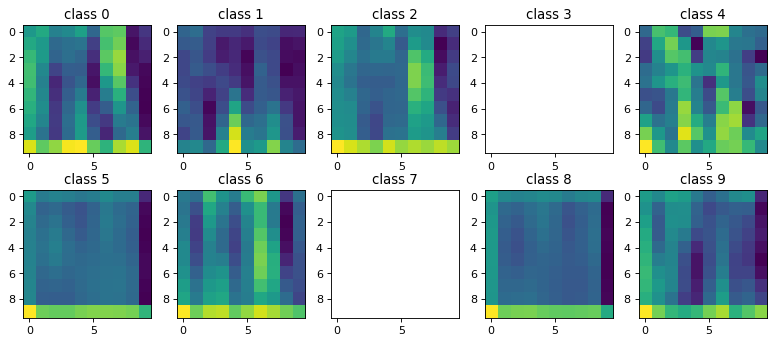

conv1 layer


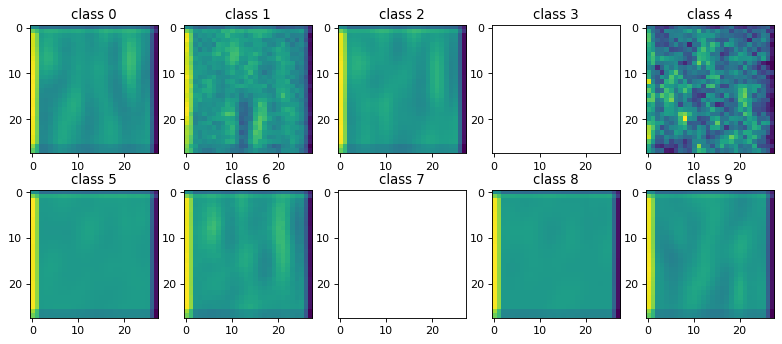

In [208]:
LoadNoiseAndPlotActs("noise_acts_MN_FashLM")

conv2


<Figure size 1050x300 with 0 Axes>

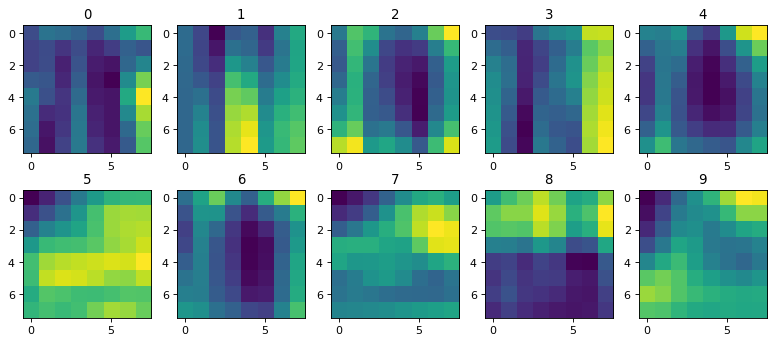

conv1


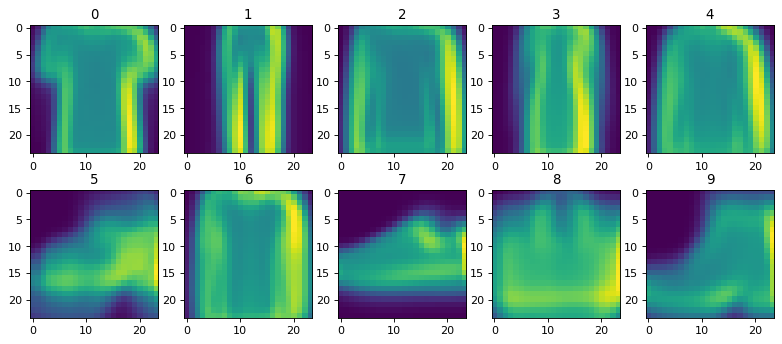

In [209]:
LoadRealDatAndPlotActs("realDat_acts_MN_FashLM",)

In [210]:
GetWNActivation(modelsecond_Fash,"noise_acts_MN_Fash2nd",20)
GetRealActivation(modelsecond_Fash,"realDat_acts_MN_Fash2nd",train_loader_FashMNIST)

File 20/20
100%|██████████| 200/200 [00:01<00:00, 123.35it/s]
235it [00:09, 25.18it/s]


conv2 layer


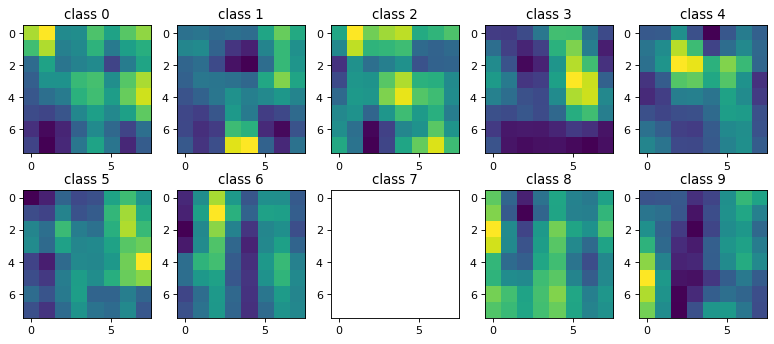

conv1 layer


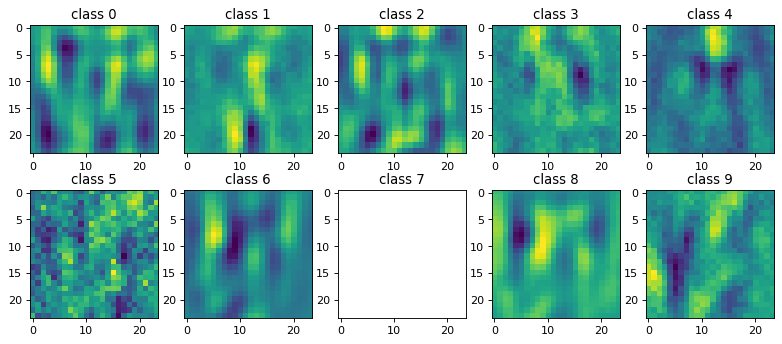

In [211]:
LoadNoiseAndPlotActs("noise_acts_MN_Fash2nd",20)

conv2


<Figure size 1050x300 with 0 Axes>

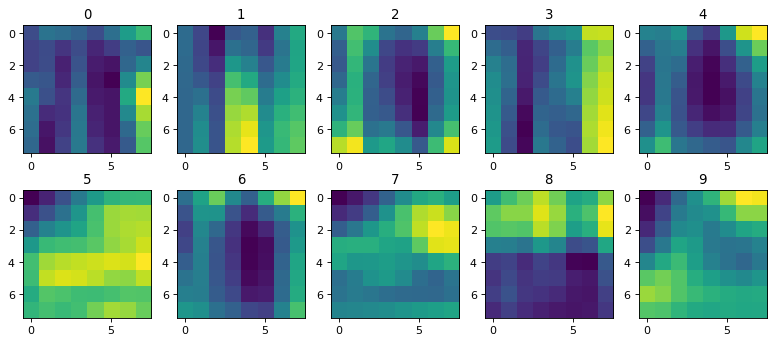

conv1


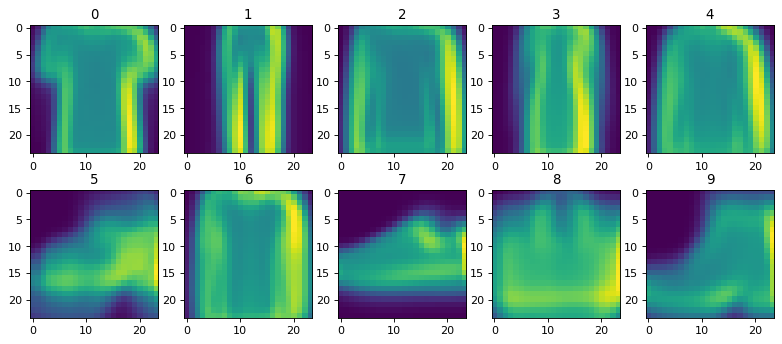

In [212]:
LoadRealDatAndPlotActs("realDat_acts_MN_Fash2nd",)

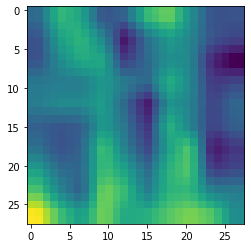

In [389]:
import cv2
#noise_acts_MN_FashLM
#f'CI_FashMNIST_LN_0.3.pt
conv2_actsFashLM, _,_ = LoadNoiseAndreturn("noise_acts_MN_FashLM",20)
k = -0.05
conv2_acts = conv2_actsFashLM
signal = test_loader_FashMNIST.dataset.data.type(torch.FloatTensor)
# signal =signal/256
C = (cv2.resize(conv2_acts[0].numpy(), (28, 28)) + 
#           cv2.resize(conv2_acts[2].numpy(), (28, 28)) +
          cv2.resize(conv2_acts[4].numpy(), (28, 28))#+ 
#           cv2.resize(conv2_acts[6].numpy(), (28, 28))
         ) / 2

plt.imshow(C)

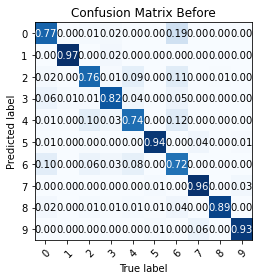

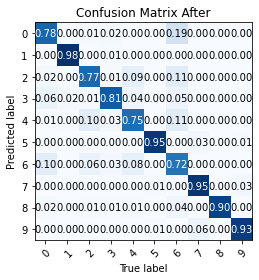

Before Accuracy 0.8541
After Accuracy 0.8583


In [390]:
finalImages = signal+ (k)*C*256
beforeAcc, afterAcc = bestModelConf(modelLN_Fash, 
                                    test_loader_FashMNIST,
                                    True,
                                    'Confusion Matrix', 
                                    finalImages)

print(f'Before Accuracy {beforeAcc}')
print(f'After Accuracy {afterAcc}')

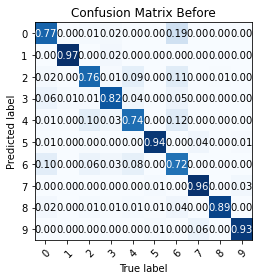

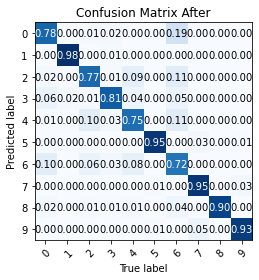

Before Accuracy 0.8541
After Accuracy 0.8579


In [391]:


import cv2
#noise_acts_MN_FashLM
conv2_actsFashLM, _,_ = LoadNoiseAndreturn("noise_acts_MN_FashLM",20)
k = -0.05
conv2_acts = conv2_actsFashLM
signal = test_loader_FashMNIST.dataset.data.type(torch.FloatTensor)
# signal =signal/256
C = (cv2.resize(conv2_acts[0].numpy(), (28, 28)) + 
          cv2.resize(conv2_acts[2].numpy(), (28, 28)) +
          cv2.resize(conv2_acts[4].numpy(), (28, 28))+ 
          cv2.resize(conv2_acts[6].numpy(), (28, 28))
         ) / 4
finalImages = signal+ (k)*C*256
beforeAcc, afterAcc = bestModelConf(modelLN_Fash, 
                                    test_loader_FashMNIST,
                                    True,
                                    'Confusion Matrix', 
                                    finalImages)

print(f'Before Accuracy {beforeAcc}')
print(f'After Accuracy {afterAcc}')

For the second CNN model classes 0, 4 and 8 were selected in a similar way. 

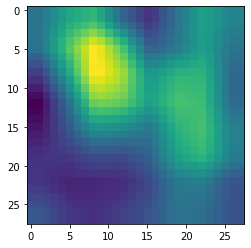

In [392]:
conv2_actsFash2nd, _,_ = LoadNoiseAndreturn("noise_acts_MN_Fash2nd",20)
import cv2
k = -0.01
signal = test_loader_FashMNIST.dataset.data.type(torch.FloatTensor)
# signal =signal/256
conv2_acts = conv2_actsFash2nd
C = (cv2.resize(conv2_acts[0].numpy(), (28, 28)) + 
        
          cv2.resize(conv2_acts[4].numpy(), (28, 28)) +
          cv2.resize(conv2_acts[6].numpy(), (28, 28))
         ) / 3

plt.imshow(C)

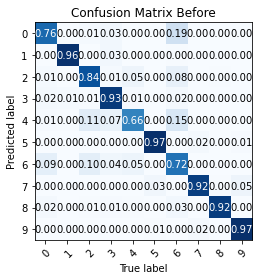

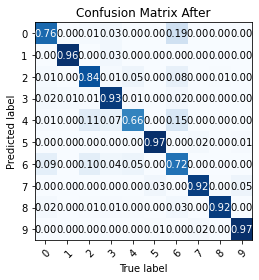

Before Accuracy 0.8619
After Accuracy 0.862


In [393]:


finalImages = signal+ (k)*C*256
beforeAcc, afterAcc = bestModelConf(modelsecond_Fash, 
                                    test_loader_FashMNIST,True,
                                    'Confusion Matrix', finalImages)

print(f'Before Accuracy {beforeAcc}')
print(f'After Accuracy {afterAcc}')

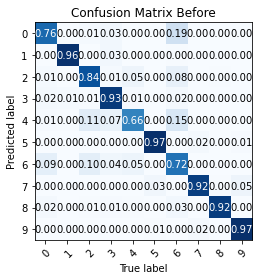

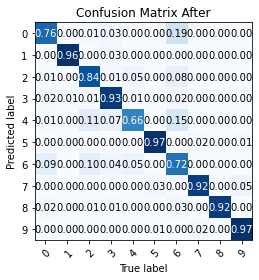

Before Accuracy 0.8619
After Accuracy 0.8619


In [394]:


CI_acts = torch.load(f'CI_FashMNIST_2ndCNN_0.3.pt')
import cv2
k = -0.01
signal = test_loader_FashMNIST.dataset.data.type(torch.FloatTensor)
# signal =signal/256
CI_acts = CI_acts 

C = (CI_acts[0].view(-1,28) + 
          CI_acts[4].view(-1,28) +
          CI_acts[6].view(-1,28)
         ) / 3
# C = (cv2.resize(conv2_acts[0].numpy(), (28, 28)) + 
        
#           cv2.resize(conv2_acts[4].numpy(), (28, 28)) +
#           cv2.resize(conv2_acts[6].numpy(), (28, 28))
#          ) / 3

# plt.imshow(C)

finalImages = signal+ (k)*C*256
beforeAcc, afterAcc = bestModelConf(modelsecond_Fash, 
                                    test_loader_FashMNIST,True,
                                    'Confusion Matrix', finalImages)

print(f'Before Accuracy {beforeAcc}')
print(f'After Accuracy {afterAcc}')

In [321]:
torch.load(f'CI_FashMNIST_2ndCNN_0.3.pt')[0].view(-1,28).shape

torch.Size([28, 28])

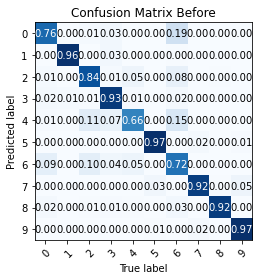

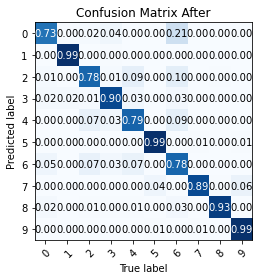

Before Accuracy 0.8619
After Accuracy 0.8752


In [323]:
# conv2_actsFash2nd, _,_ = LoadNoiseAndreturn('CI_FashMNIST_LN_0.3',20)


CI_acts = torch.load(f'CI_FashMNIST_2ndCNN_0.3.pt')
import cv2
k = -0.01
signal = test_loader_FashMNIST.dataset.data.type(torch.FloatTensor)
signal =signal/256
CI_acts = CI_acts 

C = (CI_acts[0].view(-1,28) + 
          CI_acts[4].view(-1,28) +
          CI_acts[6].view(-1,28)
         ) / 3
# C = (cv2.resize(conv2_acts[0].numpy(), (28, 28)) + 
        
#           cv2.resize(conv2_acts[4].numpy(), (28, 28)) +
#           cv2.resize(conv2_acts[6].numpy(), (28, 28))
#          ) / 3

# plt.imshow(C)

finalImages = signal+ (k)*C
beforeAcc, afterAcc = bestModelConf(modelsecond_Fash, 
                                    test_loader_FashMNIST,True,
                                    'Confusion Matrix', finalImages)

print(f'Before Accuracy {beforeAcc}')
print(f'After Accuracy {afterAcc}')

In [316]:
CI_acts.shape

torch.Size([10, 784])

In [81]:
for gamma in [0,0.1,0.2,0.3]:
    classificationImageSaver(modelLN, 
                                 test_loader_FashMNIST,
                                 10000,
                                 100, 
                                 gamma, f'FashLN_{gamma}.pt')
    saveClassImageGraphs(f'FashLN_{gamma}.pt',f'graphs/FashLN_{gamma}.png',modelLN)

99.0


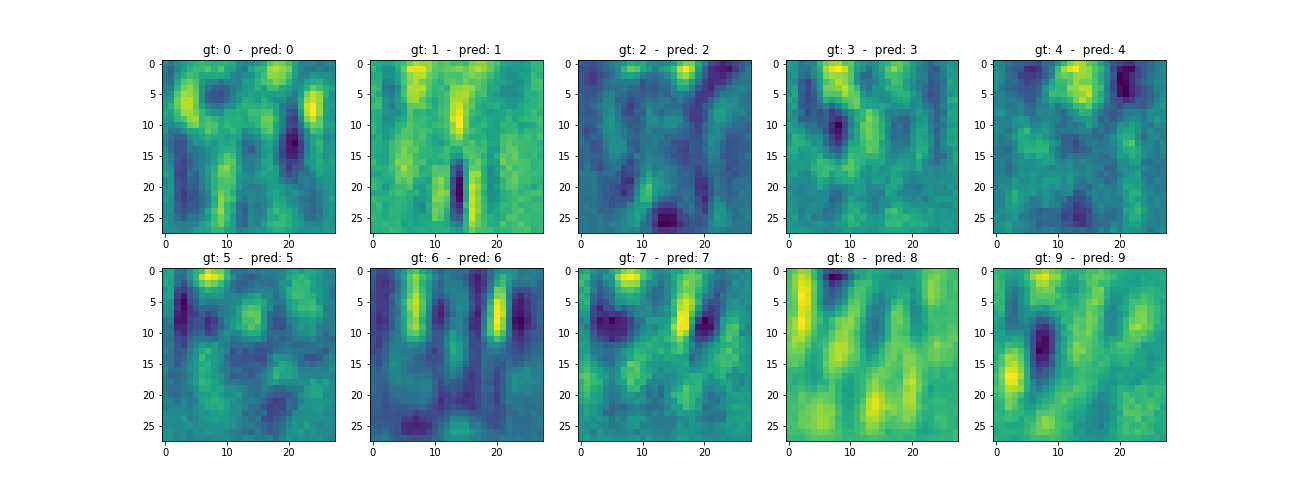

In [82]:
Image(filename=f'graphs/FashLN_0.3.png')

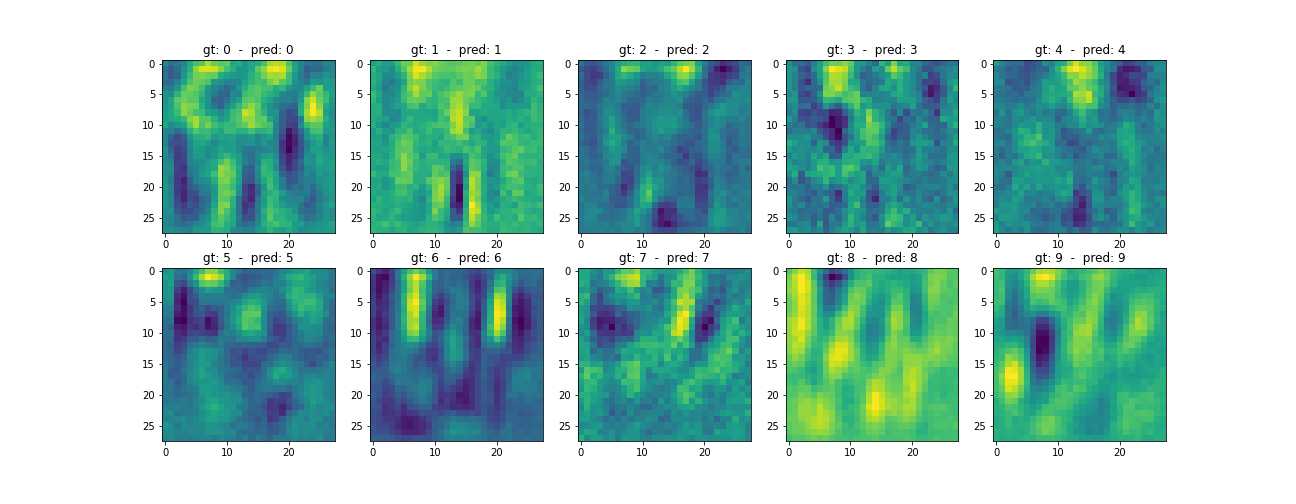

In [83]:
Image(filename=f'graphs/FashLN_0.2.png')

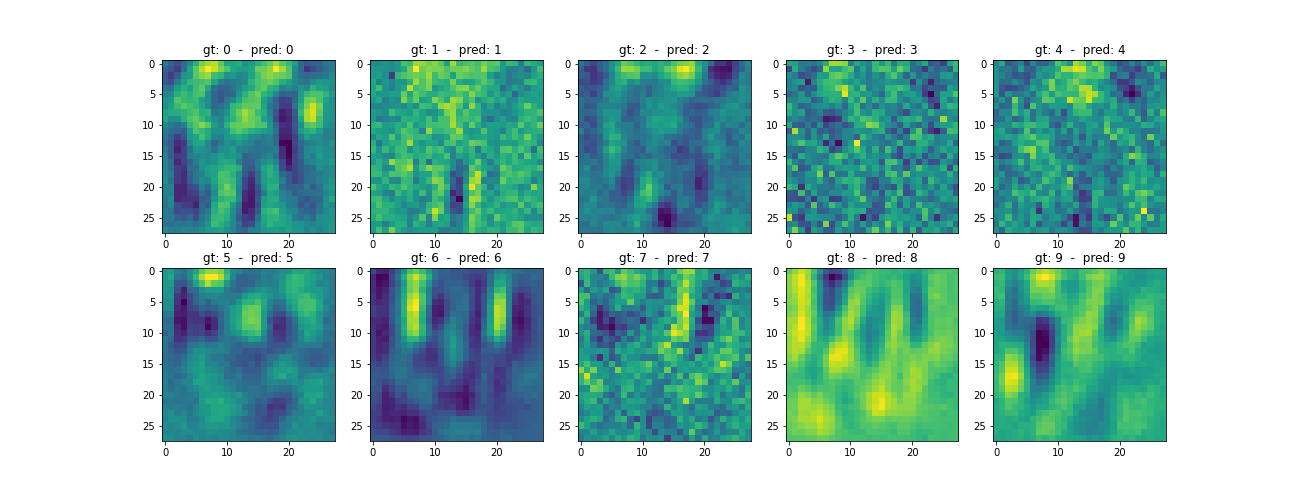

In [84]:
Image(filename=f'graphs/FashLN_0.1.png')

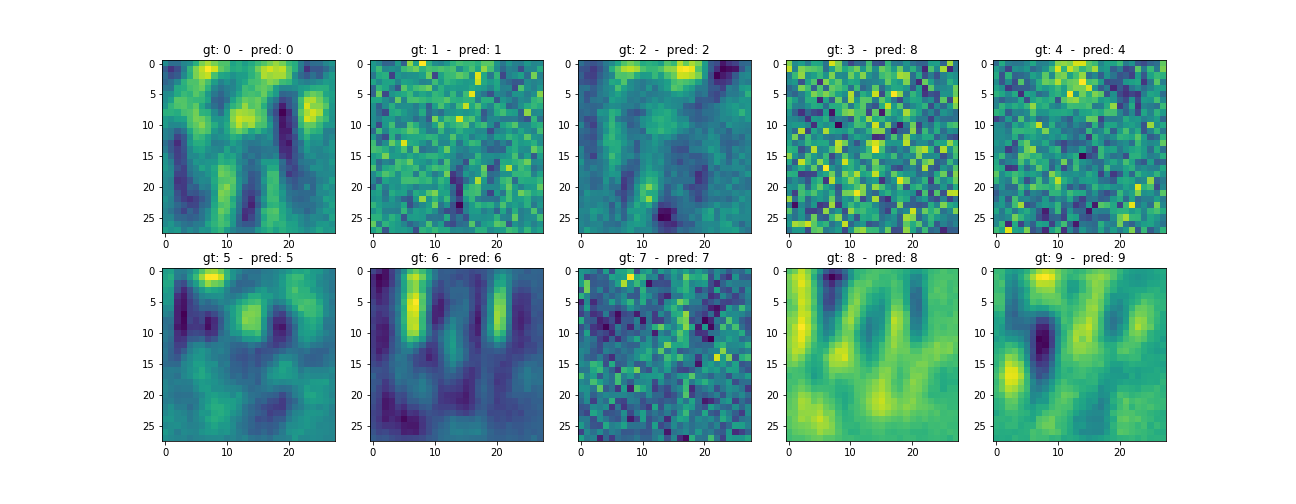

In [85]:
Image(filename=f'graphs/FashLN_0.png')

In [107]:
model2 = model_2nd_CNN()
# # trainModel(model1,  15, "testCNN",train_loaderMNIST, test_loaderMNIST)
bestFash_2nd_ModelString =trainModel(model2,  15, "2nd_FashMNIST",train_loader_FashMNIST, test_loader_FashMNIST)

print(f'best model name {bestFash_2nd_ModelString}')

 Best model saved. [51456/60000 (86%)]	Loss: 1.779993
 Train Epoch: 1/15 [60000/60000 (100%)]	Loss: 1.774005	 Test Accuracy: 70.4300%
 Train Epoch: 2/15 [25856/60000 (43%)]	Loss: 1.780879

KeyboardInterrupt: 

In [110]:
model2 = model_2nd_CNN()
model2.cuda()
bestFash_2nd_ModelString = 'MNIST_2nd_FashMNISTfin_epoch_14.pth'
model2.load_state_dict(torch.load(bestFash_2nd_ModelString)['model'])

<All keys matched successfully>

In [113]:
bestModelConf(model2, test_loader_FashMNIST)

plt.savefig('2nd_FashMNIST_TestConf.jpg')
plt.close()

<table><tr>
<td>  <img src="LeNet_FashMNIST_TestConf.jpg" alt="Drawing" style="width: 500px;"/> </td>
<td>  <img src="2nd_FashMNIST_TestConf.jpg" alt="Drawing" style="width: 500px;"/> </td>
</tr>

</table>
<figcaption align = "center"><b>Confusion matrix on Test MNIST data for LeNet Network (left) and 2nd CNN (Right) ( &gamma; = 0.3, 0.2, 0.1 and 0 (descending)  </b>

In [ ]:
z_orig = torch.load('LN_0.3.pt' )[0].view(-1,28)#transform.resize(z_orig, (28, 28))
z = signal*SNR + (1-SNR)*z_orig

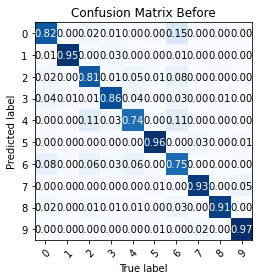

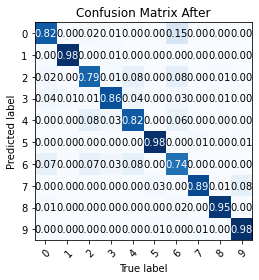

In [145]:
SNR = 0.1
signal = test_loader_FashMNIST.dataset.data.type(torch.FloatTensor)
signal =signal/256
#     z_orig =  torch.load('FashLN_0.3.pt' )[0,:] #f'{transformerPattern}'
z_orig = torch.load('LN_0.3.pt' )[8].view(-1,28)#transform.resize(z_orig, (28, 28))
z = signal+ (SNR)*z_orig
bestModelConf(model2, test_loader_FashMNIST,True,'Confusion Matrix', z)
# bestModelConf(model, test_loader,Tx=False,title = 'Confusion Matrix',TxData = None)

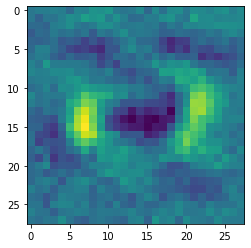

In [139]:
 plt.imshow(torch.load('LN_0.3.pt' )[0].view(-1,28))

In [86]:
for gamma in [0,0.1,0.2,0.3]:
    classificationImageSaver(model2, 
                                 test_loader_FashMNIST,
                                 10000,
                                 100, 
                                 gamma, f'Fash2nd_{gamma}.pt')
    saveClassImageGraphs(f'Fash2nd_{gamma}.pt',f'graphs/Fash2nd_{gamma}.png',model2)

99.0


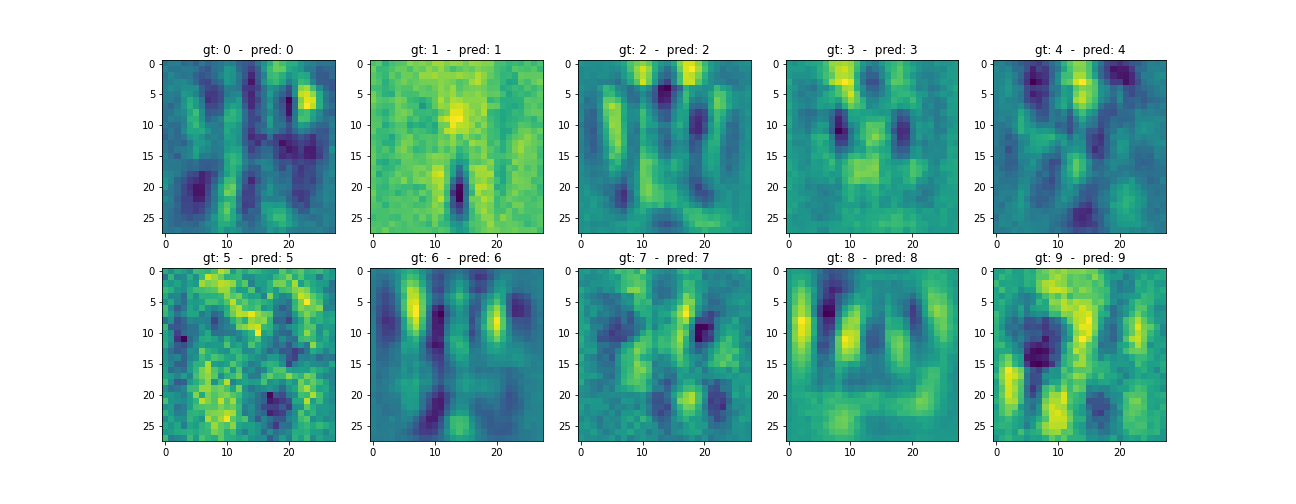

In [87]:
Image(filename=f'graphs/Fash2nd_0.3.png')

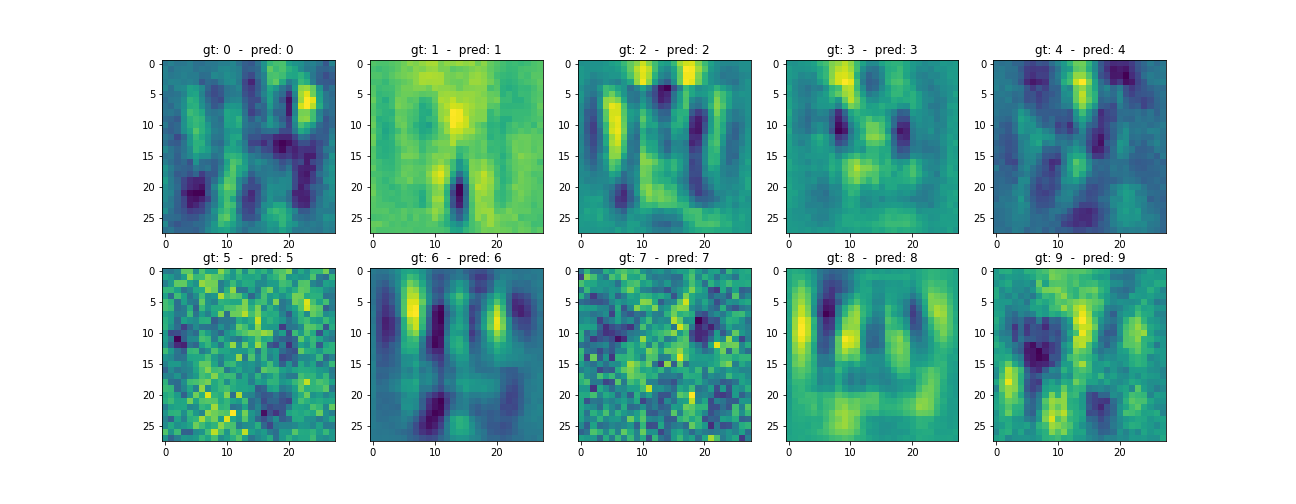

In [89]:
Image(filename=f'graphs/Fash2nd_0.2.png')

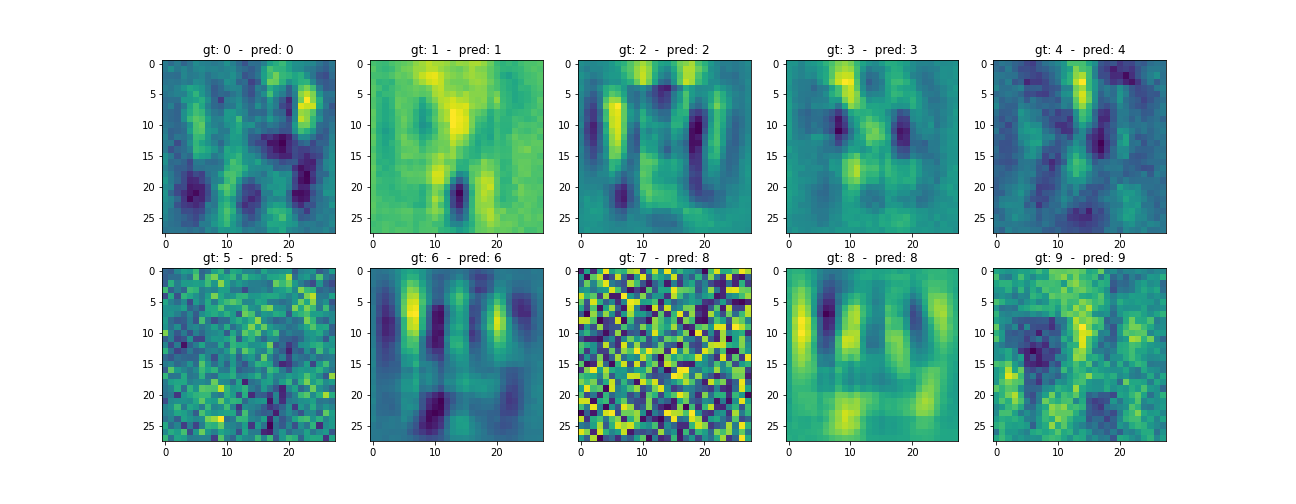

In [90]:
Image(filename=f'graphs/Fash2nd_0.1.png')

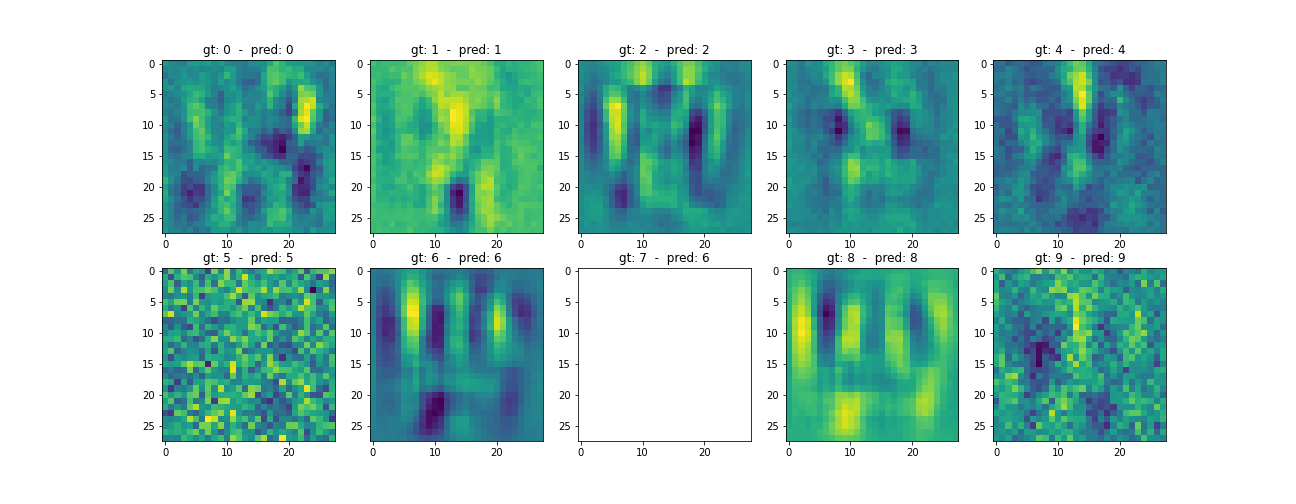

In [88]:
Image(filename=f'graphs/Fash2nd_0.png')

(10, 784)
Accuracy:  0.4965


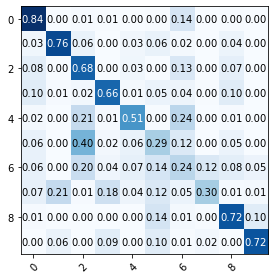

In [7]:
np.set_printoptions(precision=2)
displayDDClassifier('Fash2nd_0.3.pt',test_loader_FashMNIST)

(10, 784)
Accuracy:  0.5482


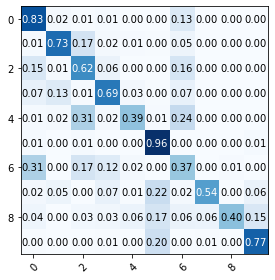

In [8]:
np.set_printoptions(precision=2)
displayDDClassifier('FashLN_0.3.pt',test_loader_FashMNIST)

In [15]:
GetWNActivation(model2,"noise_acts_FashMN_2nd")

File 20/20
100%|██████████| 200/200 [00:01<00:00, 129.25it/s]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


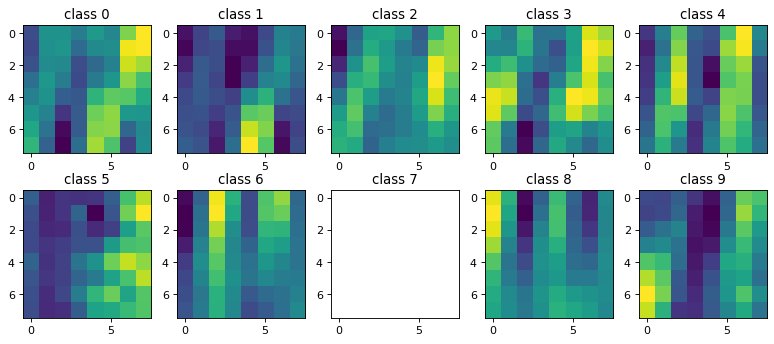

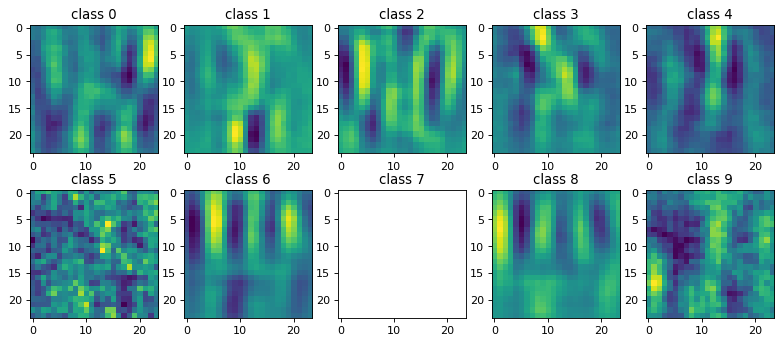

In [13]:
LoadNoiseAndPlotActs("noise_acts_FashMN_2nd")

In [18]:
GetWNActivation(modelLN,"noise_acts_FashMN_LN")

File 20/20
100%|██████████| 200/200 [00:01<00:00, 162.17it/s]


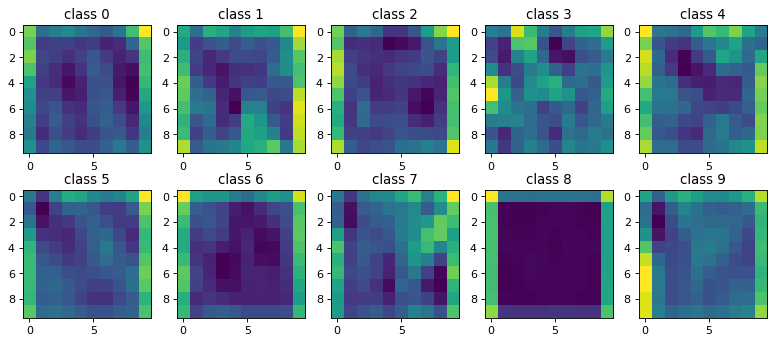

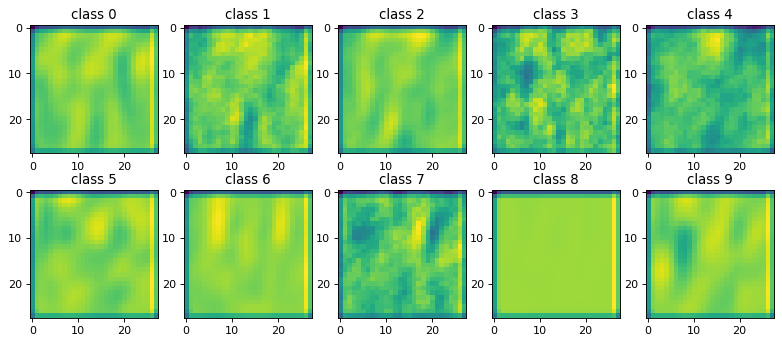

In [19]:
LoadNoiseAndPlotActs("noise_acts_FashMN_LN")

In [27]:
GetRealActivation(modelLN,"realDat_acts_FashMN_LN",train_loader_FashMNIST)

235it [00:09, 23.57it/s]


conv2


<Figure size 1050x300 with 0 Axes>

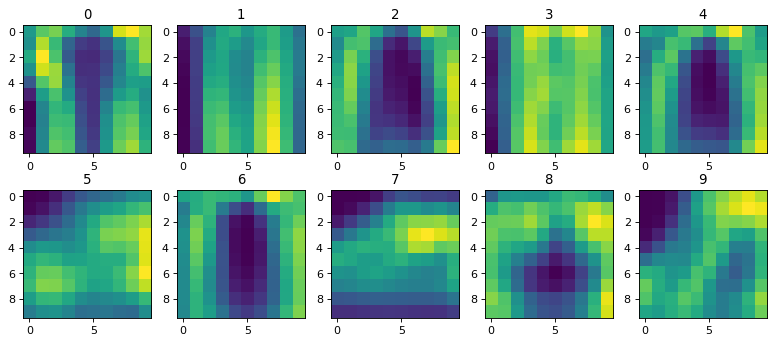

conv1


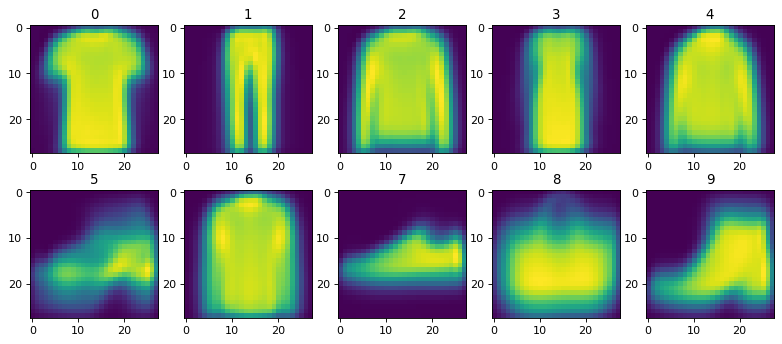

In [33]:
LoadRealDatAndPlotActs("realDat_acts_FashMN_LN",)